In [6]:
# ============================================
#  CLASSIFICATION KID-FRIENDLY - MODÉLISATION ML
# ============================================
# 
# Projet: Détection de contenu approprié pour enfants
# Dataset: Podcasts avec keywords annotés
# Objectif: Classifier kid-friendly (1) vs non kid-friendly (0)
#
# Pipeline:
# 1. Baseline Models (LR, SVM, NB)
# 2. Hyperparameter Tuning (GridSearch)
# 3. Model Selection & Evaluation
# 4. Feature Importance Analysis
# ============================================



In [7]:
# ============================================
# 1. IMPORTS ET CONFIGURATION
# ============================================

# Imports standards
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from datetime import datetime
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Machine Learning - Prétraitement
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Machine Learning - Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

# Machine Learning - Évaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 120)

# Configuration des graphiques
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("="*80)
print(" ENVIRONNEMENT ML CONFIGURÉ")
print("="*80)
print(f" Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f" Python: {pd.__version__} (pandas)")
print(f" NumPy: {np.__version__}")
print("="*80)


 ENVIRONNEMENT ML CONFIGURÉ
 Date d'exécution: 2025-12-14 15:36:10
 Python: 2.2.3 (pandas)
 NumPy: 1.26.4


In [8]:
# ============================================
# 2. CHARGEMENT DES DONNÉES ANNOTÉES
# ============================================

def load_and_explore_data(filepath='../data/annotated/podcasts_annotated.csv'):
    """
    Charge et affiche les statistiques du dataset annoté
    """
    print("\n" + "="*80)
    print(" CHARGEMENT DES DONNÉES")
    print("="*80)
    
    # Charger
    df = pd.read_csv(filepath)
    
    print(f"\n Dataset chargé: {filepath}")
    print(f"   • Nombre d'exemples: {len(df):,}")
    print(f"   • Colonnes: {list(df.columns)}")
    
    # Vérifier la colonne keywords_text
    if 'keywords_text' not in df.columns:
        print("\n  Colonne 'keywords_text' manquante, création...")
        if 'keywords_clean' in df.columns:
            df['keywords_text'] = df['keywords_clean'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))
        else:
            raise ValueError("Impossible de créer keywords_text")
    
    # Distribution de la target
    print(f"\n Distribution de la target (is_kid_friendly):")
    target_dist = df['is_kid_friendly'].value_counts()
    for label, count in target_dist.items():
        pct = count / len(df) * 100
        label_name = "Kid-Friendly" if label == 1 else "Non Kid-Friendly"
        print(f"   • {label_name} ({label}): {count:,} ({pct:.2f}%)")
    
    # Ratio de déséquilibre
    class_ratio = target_dist.min() / target_dist.max()
    print(f"\n  Ratio de déséquilibre: {class_ratio:.3f}")
    if class_ratio < 0.3:
        print(f"     Dataset déséquilibré → utiliser class_weight='balanced'")
    
    # Statistiques textuelles
    df['n_chars'] = df['keywords_text'].str.len()
    df['n_words'] = df['keywords_text'].str.split().str.len()
    
    print(f"\n Statistiques textuelles:")
    print(f"   • Mots par exemple: {df['n_words'].mean():.1f} ± {df['n_words'].std():.1f}")
    print(f"   • Min/Max mots: {df['n_words'].min()} / {df['n_words'].max()}")
    print(f"   • Caractères moyens: {df['n_chars'].mean():.0f}")
    
    # Exemples
    print(f"\n Exemples aléatoires:")
    for idx, row in df.sample(3, random_state=42).iterrows():
        label = " Kid-Friendly" if row['is_kid_friendly'] == 1 else " Non Kid-Friendly"
        keywords_preview = row['keywords_text'][:80] + "..." if len(row['keywords_text']) > 80 else row['keywords_text']
        print(f"\n   {label}")
        print(f"   Keywords: {keywords_preview}")
    
    print("\n" + "="*80)
    return df

# Charger les données
df = load_and_explore_data('../data/annotated/podcasts_annotated.csv')




 CHARGEMENT DES DONNÉES

 Dataset chargé: ../data/annotated/podcasts_annotated.csv
   • Nombre d'exemples: 419
   • Colonnes: ['id', 'title', 'keywords', 'n_keywords', 'keywords_clean', 'is_kid_friendly']

  Colonne 'keywords_text' manquante, création...

 Distribution de la target (is_kid_friendly):
   • Non Kid-Friendly (0): 307 (73.27%)
   • Kid-Friendly (1): 112 (26.73%)

  Ratio de déséquilibre: 0.365

 Statistiques textuelles:
   • Mots par exemple: 20.1 ± 7.7
   • Min/Max mots: 0 / 65
   • Caractères moyens: 160

 Exemples aléatoires:

    Non Kid-Friendly
   Keywords: mars exploration ancient technology historical anomalies lost civilization theor...

    Non Kid-Friendly
   Keywords: child abuse exoneration fathers rights group false allegation damage custody bat...

    Non Kid-Friendly
   Keywords: addiction sobriety spiritual awakening conspiracy theories media censorship poli...



In [9]:
# ============================================
# 3. PRÉPARATION TRAIN/TEST
# ============================================

def prepare_train_test_split(df, test_size=0.2, random_state=42):
    """
    Split stratifié pour préserver la distribution des classes
    """
    print("\n" + "="*80)
    print("  SPLIT TRAIN/TEST STRATIFIÉ")
    print("="*80)
    
    X = df['keywords_text']
    y = df['is_kid_friendly']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y  # Préserve la distribution
    )
    
    print(f"\n Dimensions:")
    print(f"   • Train: {len(X_train):,} exemples ({len(X_train)/len(df)*100:.1f}%)")
    print(f"   • Test:  {len(X_test):,} exemples ({len(X_test)/len(df)*100:.1f}%)")
    
    print(f"\n  Distribution Train:")
    train_dist = y_train.value_counts()
    for label, count in train_dist.items():
        print(f"   • Classe {label}: {count:,} ({count/len(y_train)*100:.2f}%)")
    
    print(f"\n  Distribution Test:")
    test_dist = y_test.value_counts()
    for label, count in test_dist.items():
        print(f"   • Classe {label}: {count:,} ({count/len(y_test)*100:.2f}%)")
    
    print("\n" + "="*80)
    return X_train, X_test, y_train, y_test

# Préparer les splits
X_train, X_test, y_train, y_test = prepare_train_test_split(df)



  SPLIT TRAIN/TEST STRATIFIÉ

 Dimensions:
   • Train: 335 exemples (80.0%)
   • Test:  84 exemples (20.0%)

  Distribution Train:
   • Classe 0: 245 (73.13%)
   • Classe 1: 90 (26.87%)

  Distribution Test:
   • Classe 0: 62 (73.81%)
   • Classe 1: 22 (26.19%)



In [16]:
# ============================================
# 4. MODÈLES BASELINE 
# ============================================

def get_baseline_models():
    """
    Définit les pipelines de modèles baseline avec TF-IDF
    Adapté aux textes courts (keywords)
    """
    
    # Paramètres TF-IDF optimisés pour keywords courts
    tfidf_params = {
        'max_features': None,      # Garder tous les mots
        'min_df': 2,               # Ignorer mots très rares
        'max_df': 0.95,            # Ignorer mots trop fréquents
        'ngram_range': (1, 2),     # Unigrammes + bigrammes
        'sublinear_tf': True       # Échelle logarithmique pour TF
    }
    
    models = {
        'Dummy (Baseline Naïve)': Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', DummyClassifier(strategy='most_frequent', random_state=42))
        ]),
        
        'Logistic Regression': Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', LogisticRegression(
                max_iter=1000,
                random_state=42,
                class_weight='balanced',  # Gère le déséquilibre
                solver='liblinear'
            ))
        ]),
        
        'Linear SVM': Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', LinearSVC(
                max_iter=2000,
                random_state=42,
                class_weight='balanced',
                dual='auto',  
                loss='squared_hinge'  
            ))
        ]),
        
        'Multinomial Naive Bayes': Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', MultinomialNB(alpha=1.0))
        ])
    }
    
    print("\n" + "="*80)
    print(" MODÈLES BASELINE CONFIGURÉS")
    print("="*80)
    print(f"\nNombre de modèles: {len(models)}")
    for i, (name, pipeline) in enumerate(models.items(), 1):
        print(f"   {i}. {name}")
    print("\n TF-IDF configuré pour textes courts (keywords):")
    print(f"   • ngram_range: {tfidf_params['ngram_range']}")
    print(f"   • min_df: {tfidf_params['min_df']}")
    print(f"   • max_df: {tfidf_params['max_df']}")
    print("="*80)
    
    return models

# Définir les modèles
baseline_models = get_baseline_models()



 MODÈLES BASELINE CONFIGURÉS

Nombre de modèles: 4
   1. Dummy (Baseline Naïve)
   2. Logistic Regression
   3. Linear SVM
   4. Multinomial Naive Bayes

 TF-IDF configuré pour textes courts (keywords):
   • ngram_range: (1, 2)
   • min_df: 2
   • max_df: 0.95


In [17]:
# ============================================
# 5. FONCTION D'ENTRAÎNEMENT ET ÉVALUATION (CORRIGÉE)
# ============================================

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Entraîne et évalue un modèle avec métriques complètes
    
    Returns:
        dict: Dictionnaire contenant toutes les métriques et prédictions
    """
    print(f"\n{'─'*80}")
    print(f" Entraînement: {model_name}")
    print(f"{'─'*80}")
    
    # Entraînement
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Prédictions probabilistes (si disponible)
    y_pred_proba = None
    try:
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'decision_function'):
            # Pour SVM, utiliser decision_function
            y_pred_proba = model.decision_function(X_test)
        elif hasattr(model.named_steps['clf'], 'decision_function'):
            # Pour Pipeline avec SVM
            y_pred_proba = model.named_steps['clf'].decision_function(
                model.named_steps['tfidf'].transform(X_test)
            )
    except Exception as e:
        # Si erreur, continuer sans probabilités
        print(f"     Impossible d'obtenir les probabilités: {str(e)[:50]}")
        y_pred_proba = None
    
    # Calcul des métriques
    results = {
        'model': model,
        'model_name': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'train_time': train_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # ROC-AUC si probabilités disponibles
    if y_pred_proba is not None:
        try:
            results['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
        except:
            results['roc_auc'] = np.nan
    else:
        results['roc_auc'] = np.nan
    
    # Affichage
    print(f" Terminé en {train_time:.2f}s")
    print(f"\n Métriques:")
    print(f"   • Accuracy:  {results['accuracy']:.4f}")
    print(f"   • Precision: {results['precision']:.4f}")
    print(f"   • Recall:    {results['recall']:.4f}")
    print(f"   • F1-Score:  {results['f1_score']:.4f}")
    if not np.isnan(results['roc_auc']):
        print(f"   • ROC-AUC:   {results['roc_auc']:.4f}")
    
    return results


In [18]:
# ============================================
# 6. ENTRAÎNEMENT BASELINE
# ============================================

print("\n" + "="*80)
print("  PHASE 1: ENTRAÎNEMENT BASELINE")
print("="*80)

baseline_results = {}

for model_name, model in baseline_models.items():
    results = train_and_evaluate_model(
        model, X_train, y_train, X_test, y_test, model_name
    )
    baseline_results[model_name] = results

print("\n" + "="*80)
print(" PHASE 1 TERMINÉE")
print("="*80)



  PHASE 1: ENTRAÎNEMENT BASELINE

────────────────────────────────────────────────────────────────────────────────
 Entraînement: Dummy (Baseline Naïve)
────────────────────────────────────────────────────────────────────────────────
 Terminé en 0.03s

 Métriques:
   • Accuracy:  0.7381
   • Precision: 0.0000
   • Recall:    0.0000
   • F1-Score:  0.0000
   • ROC-AUC:   0.5000

────────────────────────────────────────────────────────────────────────────────
 Entraînement: Logistic Regression
────────────────────────────────────────────────────────────────────────────────
 Terminé en 0.02s

 Métriques:
   • Accuracy:  0.7976
   • Precision: 0.5806
   • Recall:    0.8182
   • F1-Score:  0.6792
   • ROC-AUC:   0.9223

────────────────────────────────────────────────────────────────────────────────
 Entraînement: Linear SVM
────────────────────────────────────────────────────────────────────────────────
 Terminé en 0.01s

 Métriques:
   • Accuracy:  0.8452
   • Precision: 0.6667
   • Reca

In [21]:
# ============================================
# 7. COMPARAISON BASELINE
# ============================================

def create_comparison_table(results_dict, title="COMPARAISON DES MODÈLES"):
    """
    Crée un tableau comparatif professionnel
    """
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80 + "\n")
    
    # Créer DataFrame
    df_results = pd.DataFrame([
        {
            'Modèle': name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'ROC-AUC': results['roc_auc'],
            'Temps (s)': results['train_time']
        }
        for name, results in results_dict.items()
    ])
    
    # Trier par F1-Score décroissant
    df_results = df_results.sort_values('F1-Score', ascending=False)
    
    # Formater pour affichage
    df_display = df_results.copy()
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
        df_display[col] = df_display[col].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
    df_display['Temps (s)'] = df_display['Temps (s)'].apply(lambda x: f"{x:.2f}")
    
    print(df_display.to_string(index=False))
    print("\n" + "="*80)
    
    # Meilleur modèle
    best_model = df_results.iloc[0]
    print(f"\n MEILLEUR MODÈLE BASELINE: {best_model['Modèle']}")
    print(f"   • F1-Score: {best_model['F1-Score']:.4f}")
    print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
    print("="*80)
    
    return df_results

# Créer le tableau
df_baseline = create_comparison_table(baseline_results, "RÉSULTATS BASELINE")



 RÉSULTATS BASELINE

                 Modèle Accuracy Precision Recall F1-Score ROC-AUC Temps (s)
             Linear SVM   0.8452    0.6667 0.8182   0.7347  0.9098      0.01
    Logistic Regression   0.7976    0.5806 0.8182   0.6792  0.9223      0.02
Multinomial Naive Bayes   0.8095    0.8750 0.3182   0.4667  0.9362      0.03
 Dummy (Baseline Naïve)   0.7381    0.0000 0.0000   0.0000  0.5000      0.03


 MEILLEUR MODÈLE BASELINE: Linear SVM
   • F1-Score: 0.7347
   • Accuracy: 0.8452


In [22]:
# ============================================
# 8. CROSS-VALIDATION STRATIFIÉE
# ============================================

def perform_cross_validation(model, X_train, y_train, model_name, cv=5):
    """
    Évaluation avec cross-validation stratifiée pour robustesse statistique
    """
    print(f"\n{'─'*80}")
    print(f" Cross-Validation: {model_name} ({cv}-fold)")
    print(f"{'─'*80}")
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Métriques à calculer
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = {}
    
    start_time = time.time()
    
    for metric in scoring:
        try:
            scores = cross_val_score(
                model, X_train, y_train, 
                cv=skf, 
                scoring=metric, 
                n_jobs=-1
            )
            cv_results[f'cv_{metric}_mean'] = scores.mean()
            cv_results[f'cv_{metric}_std'] = scores.std()
            
            print(f"   • {metric.upper():12s}: {scores.mean():.4f} (±{scores.std():.4f})")
        except:
            print(f"   • {metric.upper():12s}: N/A (non supporté)")
            cv_results[f'cv_{metric}_mean'] = np.nan
            cv_results[f'cv_{metric}_std'] = np.nan
    
    cv_time = time.time() - start_time
    print(f"\n CV terminée en {cv_time:.2f}s")
    
    cv_results['cv_time'] = cv_time
    return cv_results

# Sélectionner les meilleurs modèles pour CV (exclure Dummy)
print("\n" + "="*80)
print(" PHASE 2: CROSS-VALIDATION STRATIFIÉE")
print("="*80)
print("\n Validation de la robustesse des modèles sur 5 folds stratifiés")

cv_results = {}
for model_name, model in baseline_models.items():
    if 'Dummy' not in model_name:  # Skip baseline naïve
        cv_res = perform_cross_validation(
            baseline_results[model_name]['model'],
            X_train, y_train, model_name
        )
        cv_results[model_name] = cv_res

print("\n" + "="*80)
print(" PHASE 2 TERMINÉE")
print("="*80)



 PHASE 2: CROSS-VALIDATION STRATIFIÉE

 Validation de la robustesse des modèles sur 5 folds stratifiés

────────────────────────────────────────────────────────────────────────────────
 Cross-Validation: Logistic Regression (5-fold)
────────────────────────────────────────────────────────────────────────────────
   • ACCURACY    : 0.8448 (±0.0202)
   • PRECISION   : 0.6977 (±0.0590)
   • RECALL      : 0.7667 (±0.0956)
   • F1          : 0.7249 (±0.0364)
   • ROC_AUC     : 0.8993 (±0.0467)

 CV terminée en 0.23s

────────────────────────────────────────────────────────────────────────────────
 Cross-Validation: Linear SVM (5-fold)
────────────────────────────────────────────────────────────────────────────────
   • ACCURACY    : 0.8358 (±0.0389)
   • PRECISION   : 0.7014 (±0.0924)
   • RECALL      : 0.7222 (±0.0930)
   • F1          : 0.7034 (±0.0527)
   • ROC_AUC     : 0.9018 (±0.0330)

 CV terminée en 0.23s

────────────────────────────────────────────────────────────────────────────

In [23]:
# ============================================
# 9. FINE-TUNING - GRIDSEARCHCV
# ============================================

def get_param_grids():
    """
    Définit les grilles de paramètres pour GridSearchCV
    Optimisés pour classification de textes courts (keywords)
    """
    param_grids = {
        'Logistic Regression': {
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'tfidf__min_df': [1, 2, 3],
            'tfidf__max_df': [0.9, 0.95, 1.0],
            'clf__C': [0.1, 1.0, 10.0],
            'clf__penalty': ['l2'],
            'clf__class_weight': ['balanced']
        },
        
        'Linear SVM': {
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'tfidf__min_df': [1, 2, 3],
            'tfidf__max_df': [0.9, 0.95, 1.0],
            'clf__C': [0.1, 1.0, 10.0],
            'clf__class_weight': ['balanced']
        }
    }
    
    return param_grids

def tune_model(model, param_grid, X_train, y_train, model_name, cv=5):
    """
    Fine-tuning avec GridSearchCV
    """
    print(f"\n{'─'*80}")
    print(f" Fine-Tuning: {model_name}")
    print(f"{'─'*80}")
    
    # Calculer nombre de combinaisons
    from sklearn.model_selection import ParameterGrid
    n_combinations = len(list(ParameterGrid(param_grid)))
    print(f"Configuration: {n_combinations} combinaisons × {cv}-fold CV = {n_combinations * cv} fits")
    print(f"Métrique d'optimisation: F1-Score")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=StratifiedKFold(cv, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    print(f"\n Terminé en {tuning_time:.2f}s ({tuning_time/60:.1f} min)")
    print(f"\n Meilleur score CV (F1): {grid_search.best_score_:.4f}")
    print(f"\n Meilleurs paramètres:")
    for param, value in grid_search.best_params_.items():
        print(f"   • {param:30s}: {value}")
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, tuning_time

# Exécution du Fine-Tuning
print("\n" + "="*80)
print(" PHASE 3: HYPERPARAMETER TUNING")
print("="*80)
print("\n Cette phase peut prendre plusieurs minutes...")

param_grids = get_param_grids()
tuned_models = {}
tuning_results = {}

for model_name in ['Logistic Regression', 'Linear SVM']:
    best_model, best_params, best_score, tune_time = tune_model(
        baseline_models[model_name],
        param_grids[model_name],
        X_train, y_train,
        model_name
    )
    
    tuned_models[f"{model_name} (Tuned)"] = best_model
    tuning_results[f"{model_name} (Tuned)"] = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'tuning_time': tune_time
    }

print("\n" + "="*80)
print(" PHASE 3 TERMINÉE")
print("="*80)



 PHASE 3: HYPERPARAMETER TUNING

 Cette phase peut prendre plusieurs minutes...

────────────────────────────────────────────────────────────────────────────────
 Fine-Tuning: Logistic Regression
────────────────────────────────────────────────────────────────────────────────
Configuration: 81 combinaisons × 5-fold CV = 405 fits
Métrique d'optimisation: F1-Score

 Terminé en 4.44s (0.1 min)

 Meilleur score CV (F1): 0.7358

 Meilleurs paramètres:
   • clf__C                        : 1.0
   • clf__class_weight             : balanced
   • clf__penalty                  : l2
   • tfidf__max_df                 : 0.9
   • tfidf__min_df                 : 2
   • tfidf__ngram_range            : (1, 1)

────────────────────────────────────────────────────────────────────────────────
 Fine-Tuning: Linear SVM
────────────────────────────────────────────────────────────────────────────────
Configuration: 81 combinaisons × 5-fold CV = 405 fits
Métrique d'optimisation: F1-Score

 Terminé en 4.47s (0

In [24]:
# ============================================
# 10. ÉVALUATION MODÈLES TUNED
# ============================================

print("\n" + "="*80)
print(" ÉVALUATION DES MODÈLES OPTIMISÉS SUR TEST SET")
print("="*80)

tuned_results = {}

for model_name, model in tuned_models.items():
    results = train_and_evaluate_model(
        model, X_train, y_train, X_test, y_test, model_name
    )
    tuned_results[model_name] = results



 ÉVALUATION DES MODÈLES OPTIMISÉS SUR TEST SET

────────────────────────────────────────────────────────────────────────────────
 Entraînement: Logistic Regression (Tuned)
────────────────────────────────────────────────────────────────────────────────
 Terminé en 0.01s

 Métriques:
   • Accuracy:  0.8095
   • Precision: 0.6000
   • Recall:    0.8182
   • F1-Score:  0.6923
   • ROC-AUC:   0.9230

────────────────────────────────────────────────────────────────────────────────
 Entraînement: Linear SVM (Tuned)
────────────────────────────────────────────────────────────────────────────────
 Terminé en 0.02s

 Métriques:
   • Accuracy:  0.8095
   • Precision: 0.6000
   • Recall:    0.8182
   • F1-Score:  0.6923
   • ROC-AUC:   0.9223


In [25]:
# ============================================
# 11. COMPARAISON FINALE
# ============================================

# Combiner tous les résultats
all_results = {**baseline_results, **tuned_results}

# Créer tableau comparatif
df_final = create_comparison_table(all_results, "COMPARAISON FINALE - BASELINE vs TUNED")

# Analyse de l'amélioration
print("\n" + "="*80)
print(" ANALYSE DE L'AMÉLIORATION (TUNING)")
print("="*80 + "\n")

for base_name in ['Logistic Regression', 'Linear SVM']:
    tuned_name = f"{base_name} (Tuned)"
    
    if tuned_name in tuned_results:
        base_f1 = baseline_results[base_name]['f1_score']
        tuned_f1 = tuned_results[tuned_name]['f1_score']
        improvement = ((tuned_f1 - base_f1) / base_f1) * 100
        
        print(f"🔹 {base_name}:")
        print(f"   • Baseline F1:  {base_f1:.4f}")
        print(f"   • Tuned F1:     {tuned_f1:.4f}")
        print(f"   • Amélioration: {improvement:+.2f}%")
        print()

print("="*80)



 COMPARAISON FINALE - BASELINE vs TUNED

                     Modèle Accuracy Precision Recall F1-Score ROC-AUC Temps (s)
                 Linear SVM   0.8452    0.6667 0.8182   0.7347  0.9098      0.01
Logistic Regression (Tuned)   0.8095    0.6000 0.8182   0.6923  0.9230      0.01
         Linear SVM (Tuned)   0.8095    0.6000 0.8182   0.6923  0.9223      0.02
        Logistic Regression   0.7976    0.5806 0.8182   0.6792  0.9223      0.02
    Multinomial Naive Bayes   0.8095    0.8750 0.3182   0.4667  0.9362      0.03
     Dummy (Baseline Naïve)   0.7381    0.0000 0.0000   0.0000  0.5000      0.03


 MEILLEUR MODÈLE BASELINE: Linear SVM
   • F1-Score: 0.7347
   • Accuracy: 0.8452

 ANALYSE DE L'AMÉLIORATION (TUNING)

🔹 Logistic Regression:
   • Baseline F1:  0.6792
   • Tuned F1:     0.6923
   • Amélioration: +1.92%

🔹 Linear SVM:
   • Baseline F1:  0.7347
   • Tuned F1:     0.6923
   • Amélioration: -5.77%




 ANALYSE DU MEILLEUR MODÈLE: Linear SVM


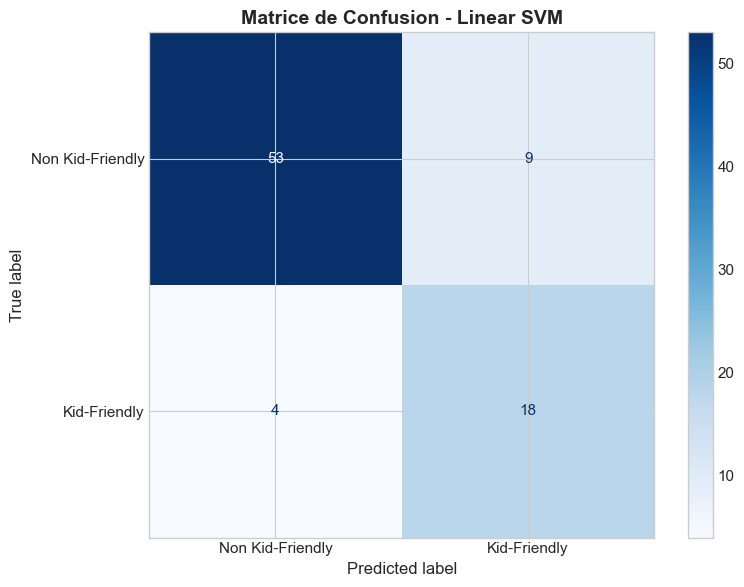


 Classification Report:

                  precision    recall  f1-score   support

Non Kid-Friendly     0.9298    0.8548    0.8908        62
    Kid-Friendly     0.6667    0.8182    0.7347        22

        accuracy                         0.8452        84
       macro avg     0.7982    0.8365    0.8127        84
    weighted avg     0.8609    0.8452    0.8499        84



In [26]:
# ============================================
# 12. VISUALISATION - MATRICE DE CONFUSION
# ============================================

# Identifier le meilleur modèle
best_model_name = df_final.iloc[0]['Modèle']
best_model_results = all_results[best_model_name]

print("\n" + "="*80)
print(f" ANALYSE DU MEILLEUR MODÈLE: {best_model_name}")
print("="*80)

# Matrice de confusion
cm = confusion_matrix(y_test, best_model_results['y_pred'])

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Non Kid-Friendly', 'Kid-Friendly']
)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Matrice de Confusion - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistiques détaillées
print(f"\n Classification Report:\n")
print(classification_report(
    y_test, 
    best_model_results['y_pred'],
    target_names=['Non Kid-Friendly', 'Kid-Friendly'],
    digits=4
))


In [29]:
# ============================================
# 13. INTERPRÉTABILITÉ - TOP KEYWORDS
# ============================================

def extract_top_keywords(model, n_top=10):
    """
    Extrait les keywords les plus discriminants pour chaque classe
    Fonctionne avec Logistic Regression et Linear SVM
    """
    print("\n" + "="*80)
    print(f" ANALYSE D'INTERPRÉTABILITÉ - TOP {n_top} KEYWORDS")
    print("="*80)
    
    # Accéder au vectorizer et classifier
    vectorizer = model.named_steps['tfidf']
    classifier = model.named_steps['clf']
    
    # Vérifier si le modèle a des coefficients
    if not hasattr(classifier, 'coef_'):
        print("\n  Ce modèle ne supporte pas l'extraction de coefficients")
        return
    
    # Extraire feature names et coefficients
    feature_names = vectorizer.get_feature_names_out()
    coefficients = classifier.coef_[0]
    
    # Top positifs (Kid-Friendly)
    top_positive_idx = np.argsort(coefficients)[-n_top:][::-1]
    
    # Top négatifs (Non Kid-Friendly)
    top_negative_idx = np.argsort(coefficients)[:n_top]
    
    print(f"\n TOP {n_top} KEYWORDS INDIQUANT 'KID-FRIENDLY':")
    print(f"{'─'*60}")
    for idx in top_positive_idx:
        keyword = feature_names[idx]
        coef = coefficients[idx]
        print(f"   • {keyword:30s}  (coef: {coef:+.4f})")
    
    print(f"\n TOP {n_top} KEYWORDS INDIQUANT 'NON KID-FRIENDLY':")
    print(f"{'─'*60}")
    for idx in top_negative_idx:
        keyword = feature_names[idx]
        coef = coefficients[idx]
        print(f"   • {keyword:30s}  (coef: {coef:+.4f})")
    
    print("\n" + "="*80)
    
    return {
        'positive_keywords': [(feature_names[idx], coefficients[idx]) for idx in top_positive_idx],
        'negative_keywords': [(feature_names[idx], coefficients[idx]) for idx in top_negative_idx]
    }

# Extraire les keywords du meilleur modèle
if 'Logistic' in best_model_name or 'SVM' in best_model_name:
    keywords_analysis = extract_top_keywords(best_model_results['model'], n_top=10)
else:
    print(f"\n  Le modèle {best_model_name} ne supporte pas l'analyse de keywords")



 ANALYSE D'INTERPRÉTABILITÉ - TOP 10 KEYWORDS

 TOP 10 KEYWORDS INDIQUANT 'KID-FRIENDLY':
────────────────────────────────────────────────────────────
   • science                         (coef: +1.0369)
   • gaming                          (coef: +0.8794)
   • longevity                       (coef: +0.8715)
   • privacy                         (coef: +0.8543)
   • athlete                         (coef: +0.8523)
   • preservation                    (coef: +0.8431)
   • learning                        (coef: +0.8329)
   • commentary                      (coef: +0.7837)
   • scientific                      (coef: +0.7808)
   • protocols                       (coef: +0.7138)

 TOP 10 KEYWORDS INDIQUANT 'NON KID-FRIENDLY':
────────────────────────────────────────────────────────────
   • secrets                         (coef: -1.1111)
   • crime                           (coef: -0.9602)
   • relationship                    (coef: -0.7884)
   • war                             (coef: -0.748

In [30]:
# ============================================
# 14. SAUVEGARDE DU MEILLEUR MODÈLE
# ============================================

def save_best_model(model, model_name, results, output_dir='../results/models'):
    """
    Sauvegarde le meilleur modèle et ses métadonnées
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Créer nom de fichier
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_filename = f"{output_dir}/best_model_{timestamp}.pkl"
    metadata_filename = f"{output_dir}/model_metadata_{timestamp}.txt"
    
    # Sauvegarder le modèle
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    
    # Sauvegarder métadonnées
    metadata = f"""
{'='*80}
MODÈLE SAUVEGARDÉ - KID-FRIENDLY CLASSIFICATION
{'='*80}

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Modèle: {model_name}

PERFORMANCES SUR TEST SET:
  • Accuracy:  {results['accuracy']:.4f}
  • Precision: {results['precision']:.4f}
  • Recall:    {results['recall']:.4f}
  • F1-Score:  {results['f1_score']:.4f}
  • ROC-AUC:   {results['roc_auc']:.4f}

TEMPS D'ENTRAÎNEMENT: {results['train_time']:.2f}s

FICHIER: {model_filename}

{'='*80}
"""
    
    with open(metadata_filename, 'w') as f:
        f.write(metadata)
    
    print("\n" + "="*80)
    print(" SAUVEGARDE DU MEILLEUR MODÈLE")
    print("="*80)
    print(f"\n Modèle sauvegardé:")
    print(f"    {model_filename}")
    print(f"\n Métadonnées sauvegardées:")
    print(f"    {metadata_filename}")
    print("\n" + "="*80)
    
    return model_filename, metadata_filename

# Sauvegarder le meilleur modèle
model_file, meta_file = save_best_model(
    best_model_results['model'],
    best_model_name,
    best_model_results
)



 SAUVEGARDE DU MEILLEUR MODÈLE

 Modèle sauvegardé:
    ../results/models/best_model_20251214_155755.pkl

 Métadonnées sauvegardées:
    ../results/models/model_metadata_20251214_155755.txt



In [ ]:
# ============================================
# 15. RAPPORT FINAL
# ============================================

print("\n" + "="*80)
print(" RAPPORT FINAL - PIPELINE ML KID-FRIENDLY CLASSIFICATION")
print("="*80)

print(f"""
 OBJECTIF ACCOMPLI
{'─'*80}
Classification automatique de podcasts basée sur keywords pour déterminer
si le contenu est approprié pour enfants.

 DATASET
{'─'*80}
  • Total exemples:     {len(df):,}
  • Split Train/Test:   {len(X_train):,} / {len(X_test):,}
  • Distribution:       {y_train.sum():,} kid-friendly, {(~y_train.astype(bool)).sum():,} non kid-friendly

 MODÈLES ÉVALUÉS
{'─'*80}
  • Baseline:           {len([k for k in baseline_results if 'Dummy' not in k])} modèles
  • Fine-Tuned:         {len(tuned_results)} modèles
  • Total comparés:     {len(all_results)} modèles

 MEILLEUR MODÈLE: {best_model_name}
{'─'*80}
  • F1-Score:           {best_model_results['f1_score']:.4f}
  • Precision:          {best_model_results['precision']:.4f}
  • Recall:             {best_model_results['recall']:.4f}
  • ROC-AUC:            {best_model_results['roc_auc']:.4f}
  • Temps training:     {best_model_results['train_time']:.2f}s

 MÉTHODOLOGIE
{'─'*80}
   *Split stratifié pour préserver distribution des classes
   *TF-IDF optimisé pour textes courts (keywords)
   *Cross-validation stratifiée (5-fold)
   *Hyperparameter tuning avec GridSearchCV
   *Évaluation multi-métriques (Acc, Prec, Rec, F1, AUC)
   *Analyse d'interprétabilité (top keywords)
   *Sauvegarde du meilleur modèle


""")

print(f" Pipeline ML complété avec succès!")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)



 RAPPORT FINAL - PIPELINE ML KID-FRIENDLY CLASSIFICATION

 OBJECTIF ACCOMPLI
────────────────────────────────────────────────────────────────────────────────
Classification automatique de podcasts basée sur keywords pour déterminer
si le contenu est approprié pour enfants.

 DATASET
────────────────────────────────────────────────────────────────────────────────
  • Total exemples:     419
  • Split Train/Test:   335 / 84
  • Distribution:       90 kid-friendly, 245 non kid-friendly

 MODÈLES ÉVALUÉS
────────────────────────────────────────────────────────────────────────────────
  • Baseline:           3 modèles
  • Fine-Tuned:         2 modèles
  • Total comparés:     6 modèles

 MEILLEUR MODÈLE: Linear SVM
────────────────────────────────────────────────────────────────────────────────
  • F1-Score:           0.7347
  • Precision:          0.6667
  • Recall:             0.8182
  • ROC-AUC:            0.9098
  • Temps training:     0.01s

 MÉTHODOLOGIE
──────────────────────────────

In [ ]:
%